See go/flax-air

### JAX Linear Classifier

#### Fetch data

In [ ]:
# Our one stop shop for datasets. If you use dataset preprocessing, then those
# computations will be performed with a Tensorflow graph. But we don't really
# need to understand the details, but rather use the API to stream through the
# dataset and then use JAX for computations.
import tensorflow_datasets as tfds

In [ ]:
# Don't like fashion? Go checkout the other image classification datasets:
# https://www.tensorflow.org/datasets/catalog/overview#image_classification
# (actually, go and check them out, even if you like fashion...)
ds, ds_info = tfds.load('fashion_mnist', with_info=True)

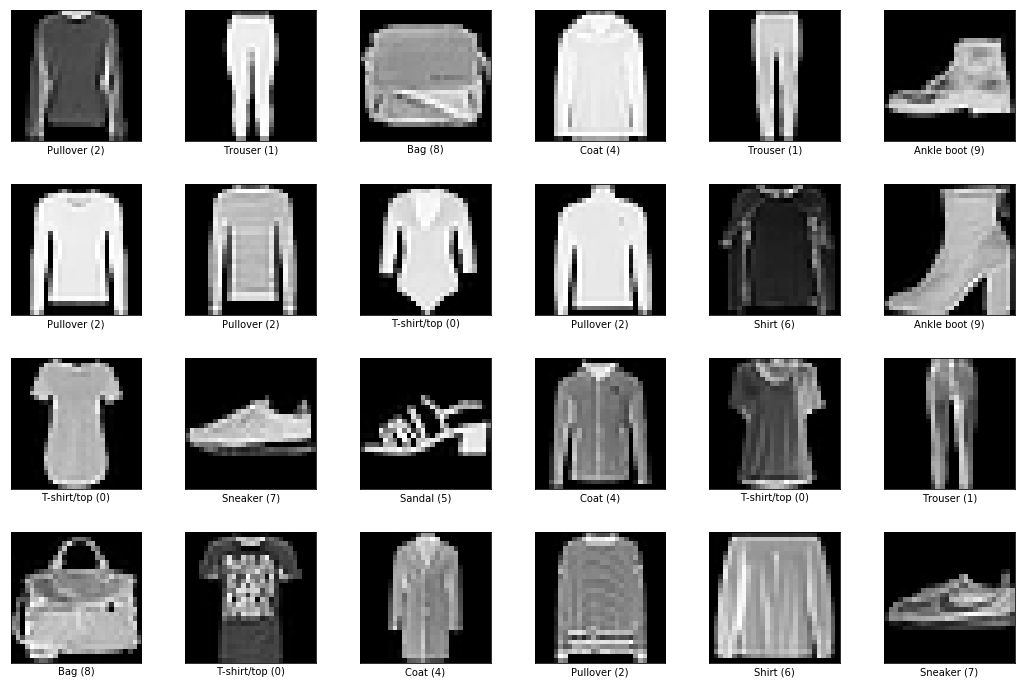

In [ ]:
tfds.show_examples(ds['train'], ds_info, rows=4, cols=6);

In [ ]:
# We're not really interested in tf.data preprocessing here, so let's just fetch
# all the data as a jax.ndarray...

def ds_get_all(ds, *keys):
  """Returns jnp.array() for specified `keys` from entire dataset `ds`."""
  d = next(iter(ds.batch(ds.cardinality())))
  return tuple(jnp.array(d[key]._numpy()) for key in keys)

train_images, train_labels = ds_get_all(ds['train'], 'image', 'label')
train_images /= 255.
test_images, test_labels = ds_get_all(ds['test'], 'image', 'label')
test_images /= 255.

train_images.shape, train_labels.shape  # labels as indices, not one-hot

((60000, 28, 28, 1), (60000,))

#### Step 1 : Define a model

In [ ]:
# YOUR ACTION REQUIRED:
# Implement the body of this function.
def linear_init(key, input_shape, n_classes):
  """Initializes parameters for a linear classifier.

  Args:
    key: a PRNGKey used as the random key.
    input_shape: Shape of a single input example.
    n_classes: Number of output classes.

  Returns:
    A pytree to be used as a first argument with `linear_apply()`.
  """
  pass

# YOUR ACTION REQUIRED:
# Implement the body of this function.
def linear_apply(params, inp):
  """Computes logits for a SINGLE EXAMPLE.

  Args:
    params: A pytree as returned by `linear_init()`.
    inp: A single input example.
    
  Returns:
    Logits (i.e. values that should be normalized by `jax.nn.softmax()` to get a
    valid probability distribution over the output classes).
  """
  pass

##-snip
def linear_init(key, input_shape, n_classes):
  dims = np.prod(input_shape)
  keys = jax.random.split(key, 2)
  # We could use some fancier initializer from `jax.nn.initializers`, but normal
  # will do just fine...
  return dict(
      W=jax.random.normal(keys[0], (dims, n_classes)),
      b=jax.random.normal(keys[1], (n_classes,))
  )

def linear_apply(params, inp):
  # Note that we operate on single examples, so inp.ravel() fits our needs.
  return inp.ravel() @ params['W'] + params['b']

In [ ]:
# Initialize classifier & run on a single example.

params = linear_init(
    key=jax.random.PRNGKey(0),
    input_shape=train_images[0].shape,
    n_classes=ds_info.features['label'].num_classes,
)
print(jax.tree_map(jnp.shape, params))
linear_apply(params, train_images[0])

{'W': (784, 10), 'b': (10,)}


DeviceArray([-17.272     ,  -1.5851411 ,   2.8681917 ,  -3.3580024 ,
              -7.041546  ,   0.61857724,   1.9804057 ,   3.5731184 ,
              -1.0657921 ,  10.262352  ], dtype=float32)

#### Step 2 : Define a loss

In [ ]:
def loss_fun(params, inputs, targets):
  """Compute x-entropy loss for a batch of images.

  Args:
    params: a pytree as returned by `linear_init()`.
    inputs: batch of images
    targets: batch of target labels (indices)

  Returns:
    The loss value.
  """
  # Note that we defined linear_apply() for a single example and how we use
  # `vmap()` here to vectorize the function.
  logits = jax.vmap(linear_apply, in_axes=(None, 0))(params, inputs)
  # We go from logits directly to log(probs):
  logprobs = logits - jax.scipy.special.logsumexp(logits, axis=-1, keepdims=True)
  # Note: targets are indices.
  return -logprobs[jnp.arange(len(targets)), targets].mean()

loss_fun(params, train_images[:2], train_labels[:2])

DeviceArray(8.0965185, dtype=float32)

#### Step 3 : `update_step()`

In [ ]:
# This is a good moment to compile our computations using `jit()` !
# REMEMBER: Since we "bake in" all globals when `jit()` is called, you will need
# to re-execute this cell every time you change some code `update_step()`
# depends on (like e.g. `loss_fun()`, or `linear_apply()`).
@jax.jit
def update_step(params, inputs, targets):
  """Take a single optimization step.

  Args:
    params: A pytree as returned by `linear_init()`.
    inputs: batch of images
    targets: batch of target labels (indices)

  Returns:
    A tuple (updated_params, loss).
  """
  loss, grads = jax.value_and_grad(loss_fun)(params, inputs, targets)
  # Opimize using SGD
  updated_params = jax.tree_multimap(
      lambda param, grad: param - .05 * grad, params, grads)
  return updated_params, loss

update_step(params, train_images[:2], train_labels[:2])

({'W': DeviceArray([[-0.89952517,  0.04048959,  0.830185  , ..., -1.5986661 ,
                -1.6399406 , -0.0504347 ],
               [ 0.5218154 ,  0.25257048, -0.7671469 , ..., -1.1277319 ,
                 0.12183627,  0.43393505],
               [ 0.4640408 ,  1.5698208 , -3.386474  , ...,  1.8135272 ,
                 0.82659805,  1.0483649 ],
               ...,
               [ 0.19173646,  0.10736103, -0.9467163 , ..., -0.8513134 ,
                 0.30983913, -1.4263569 ],
               [-0.67944413, -1.0121477 ,  1.0027933 , ..., -1.0422167 ,
                 0.99967957,  2.146934  ],
               [-1.7647744 ,  0.47946924, -1.0174353 , ..., -0.4027066 ,
                 0.76593786,  0.33410916]], dtype=float32),
  'b': DeviceArray([-0.3881249 , -0.01987561, -2.0177624 ,  0.07932307,
                0.33349887,  0.7710066 , -1.4412048 , -1.6930206 ,
               -0.37369114, -1.5650562 ], dtype=float32)},
 DeviceArray(8.0965185, dtype=float32))

#### Step 4: Train the model

final loss: 1.0864766


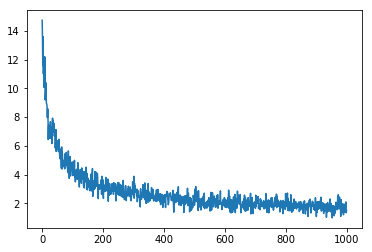

In [ ]:
# Step 4 : Do the training by calling `update_step()` repeatedly.

def train(params, steps, batch_size=128):
  losses = []
  steps_per_epoch = len(train_images) // batch_size
  for step in range(steps):
    i0 = (step % steps_per_epoch) * batch_size
    # Training is simply done by calling `update_step()` repeatedly and
    # replacing `params` with `updated_params` returned by `update_step()`.
    params, loss = update_step(
        params, train_images[i0: i0+batch_size], train_labels[i0: i0+batch_size])
    losses.append(float(loss))
  return params, jnp.array(losses)

learnt_params, losses = train(params, steps=1_000)
plt.plot(losses)
print('final loss:', np.mean(losses[-100]))

In [ ]:
# Compute accuracy of linear model.

def accuracy(params, inputs, targets):
  logits = jax.vmap(linear_apply, in_axes=(None, 0))(params, inputs)
  return (targets == logits.argmax(axis=-1)).mean()

accuracy(learnt_params, test_images, test_labels)

DeviceArray(0.6544, dtype=float32)

### end